In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam

# Load Dataset
from torchvision.datasets import GTSRB
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Resize all images to 32x32
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

# Load GTSRB Dataset with transformations
dataset = GTSRB(root='./data', split='train', download=True, transform=transform)

# Convert Dataset to Numpy Arrays
data_loader = DataLoader(dataset, batch_size=len(dataset))
data = next(iter(data_loader))

# Extract data and labels
X = data[0].numpy().reshape(len(dataset), -1)  # Flatten images
y = data[1].numpy()

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Data Preprocessing
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

100%|██████████| 187M/187M [00:11<00:00, 16.3MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


In [2]:
mlp_params = {
    'hidden_layer_sizes': [(128,), (128, 64), (64, 32)],
    'activation': ['relu', 'tanh'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200, 300]
}

mlp_grid = GridSearchCV(MLPClassifier(random_state=42), mlp_params, cv=3, scoring='accuracy')
mlp_grid.fit(X_train_scaled, y_train)

# En iyi MLP modelini alma
best_mlp = mlp_grid.best_estimator_
print("En İyi MLP Parametreleri:", mlp_grid.best_params_)

# MLP tahminleri
mlp_predictions = best_mlp.predict(X_test_scaled)

En İyi MLP Parametreleri: {'activation': 'relu', 'hidden_layer_sizes': (64, 32), 'learning_rate_init': 0.001, 'max_iter': 200}


In [3]:
rbf_model = Sequential([
    Input(shape=(X_train_scaled.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(len(np.unique(y_train)), activation='softmax')
])

rbf_model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history = rbf_model.fit(X_train_scaled, y_train, epochs=30, batch_size=32, validation_split=0.2)

# RBF tahminleri
rbf_predictions = np.argmax(rbf_model.predict(X_test_scaled), axis=1)

Epoch 1/30
533/533 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.3461 - loss: 2.5858 - val_accuracy: 0.6897 - val_loss: 1.0831
Epoch 2/30
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7293 - loss: 0.9150 - val_accuracy: 0.7919 - val_loss: 0.7572
Epoch 3/30
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8195 - loss: 0.5942 - val_accuracy: 0.8217 - val_loss: 0.6104
Epoch 4/30
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8566 - loss: 0.4647 - val_accuracy: 0.8262 - val_loss: 0.6013
Epoch 5/30
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8727 - loss: 0.4423 - val_accuracy: 0.8787 - val_loss: 0.4473
Epoch 6/30
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8954 - loss: 0.3624 - val_accuracy: 0.8571 - val_loss: 0.4638
Epoch 7/30
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9084 - loss: 0.2946 - val_accuracy: 0.8616 - val_loss: 0.5098
Epoch 8/30
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9013 - loss: 0.3421 - val_accuracy: 

MLP Classification Report
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        30
           1       0.95      0.96      0.96       300
           2       0.95      0.96      0.95       300
           3       0.92      0.80      0.86       192
           4       0.95      0.97      0.96       264
           5       0.90      0.94      0.92       252
           6       0.98      1.00      0.99        60
           7       0.92      0.95      0.93       192
           8       0.82      0.99      0.89       192
           9       0.99      0.94      0.96       198
          10       1.00      0.96      0.98       270
          11       0.99      0.96      0.97       180
          12       0.98      1.00      0.99       282
          13       0.98      0.98      0.98       288
          14       0.99      0.99      0.99       108
          15       0.94      0.95      0.95        84
          16       1.00      1.00      1.00        60
 

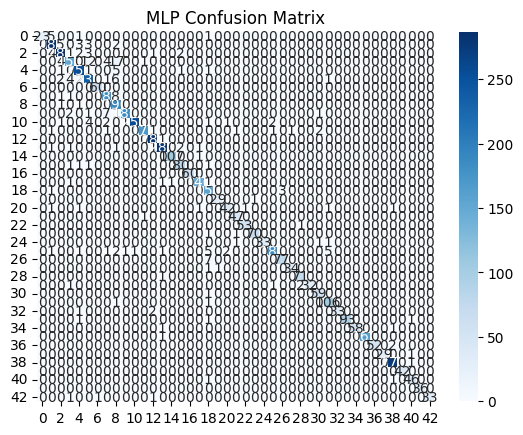

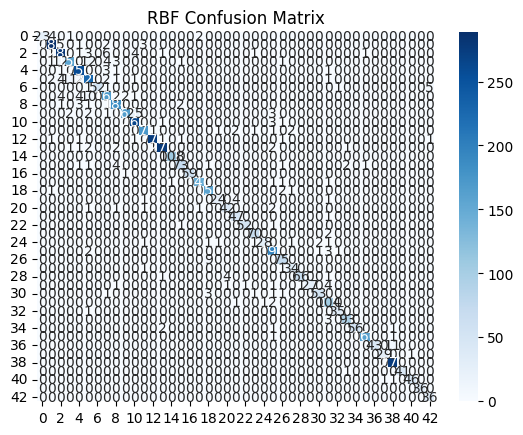

In [4]:
print("MLP Classification Report")
print(classification_report(y_test, mlp_predictions))

# RBF performans metrikleri
print("RBF Classification Report")
print(classification_report(y_test, rbf_predictions))

# Karışıklık Matrisi Görselleştirme (MLP)
mlp_cm = confusion_matrix(y_test, mlp_predictions)
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues')
plt.title('MLP Confusion Matrix')
plt.show()

# Karışıklık Matrisi Görselleştirme (RBF)
rbf_cm = confusion_matrix(y_test, rbf_predictions)
sns.heatmap(rbf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('RBF Confusion Matrix')
plt.show()

Model Performans Karşılaştırması
  Model  Accuracy
0   MLP  0.956832
1   RBF  0.940691


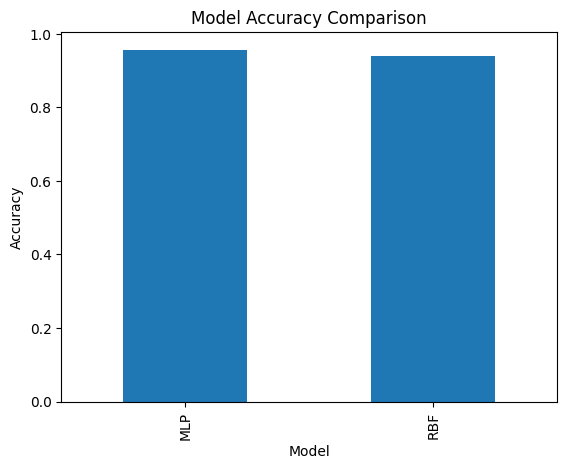

In [5]:
mlp_accuracy = accuracy_score(y_test, mlp_predictions)
rbf_accuracy = accuracy_score(y_test, rbf_predictions)

results = pd.DataFrame({
    "Model": ["MLP", "RBF"],
    "Accuracy": [mlp_accuracy, rbf_accuracy]
})

print("Model Performans Karşılaştırması")
print(results)

# Performans grafiği
results.plot(x='Model', y='Accuracy', kind='bar', legend=False)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.show()